# Analyzing and Predicting Facebook Post Lifetime Engaged Users

### Project Structure
1. Project Question and Dataset Description
2. Loading and viewing dataset
3. Pre-processing
4. Exploratory Data Analysis
5. Modeling 
    - Outlier removal and re-shaping dataframe
    - Linear Regression
    - Random Forest Regression
6. Take-aways
7. References

Data comes via the UCI dataset: https://archive.ics.uci.edu/ml/datasets/Facebook+metrics

## 1. Question: Which posts reach the most amount of users, and can we predict how many users a post wil reach?
#### Assumptions:
- higher Facebook engagement leads to more downloads and overall engagement with the app
- There have been no changes in FB's feed algorithm since the data was posted (it has been already)

#### Dataset info
##### Variables
- Page total likes: how many likes the page had when post went live
- Type: what kind of post (video, link, status, photo)
- Category: not sure, 3 levels
- Post Month
- Post Weekday
- Post Hour
- Paid
- like
- share
- comment
- total interactions
- Lifetime Post metrics (recorded after posting, EDA only)
- Lifetime Post Total Reach  (this will be the modeling variable)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 2. Loading and Viewing the data

In [2]:
df = pd.read_csv("dataset_Facebook.csv",delimiter=';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
Page total likes                                                       500 non-null int64
Type                                                                   500 non-null object
Category                                                               500 non-null int64
Post Month                                                             500 non-null int64
Post Weekday                                                           500 non-null int64
Post Hour                                                              500 non-null int64
Paid                                                                   499 non-null float64
Lifetime Post Total Reach                                              500 non-null int64
Lifetime Post Total Impressions                                        500 non-null int64
Lifetime Engaged Users                                                 500 non-nul

In [4]:
df.head(3)

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80


Because columns 7 to 15 ("Lifetime post total impressions","Lifetime Engaged users", etc.) are recorded after posting, they will not be used for modeling. However, they can give useful information about post reach, and we will be looking at them in EDA.

In [766]:

#df.drop(df.columns[7:15],
#        axis=1,inplace=True)

We need to fill the values that are blank with 0:

Goal: predict Total Interactions based on features

I have excluded comment, like, and share and instead focused on Total Interactions, which is what we will be modeling for. 

An outlier is easily visible for total interactions, at around 6000. 

### Pre-processing

In [5]:
df['Paid'].value_counts()
df['like'].fillna(0,inplace=True)
df['share'].fillna(0,inplace=True)
df['Paid'].fillna(0,inplace=True)

In [62]:
#df.drop(df.columns[1],axis=1,inplace = True)

## EDA

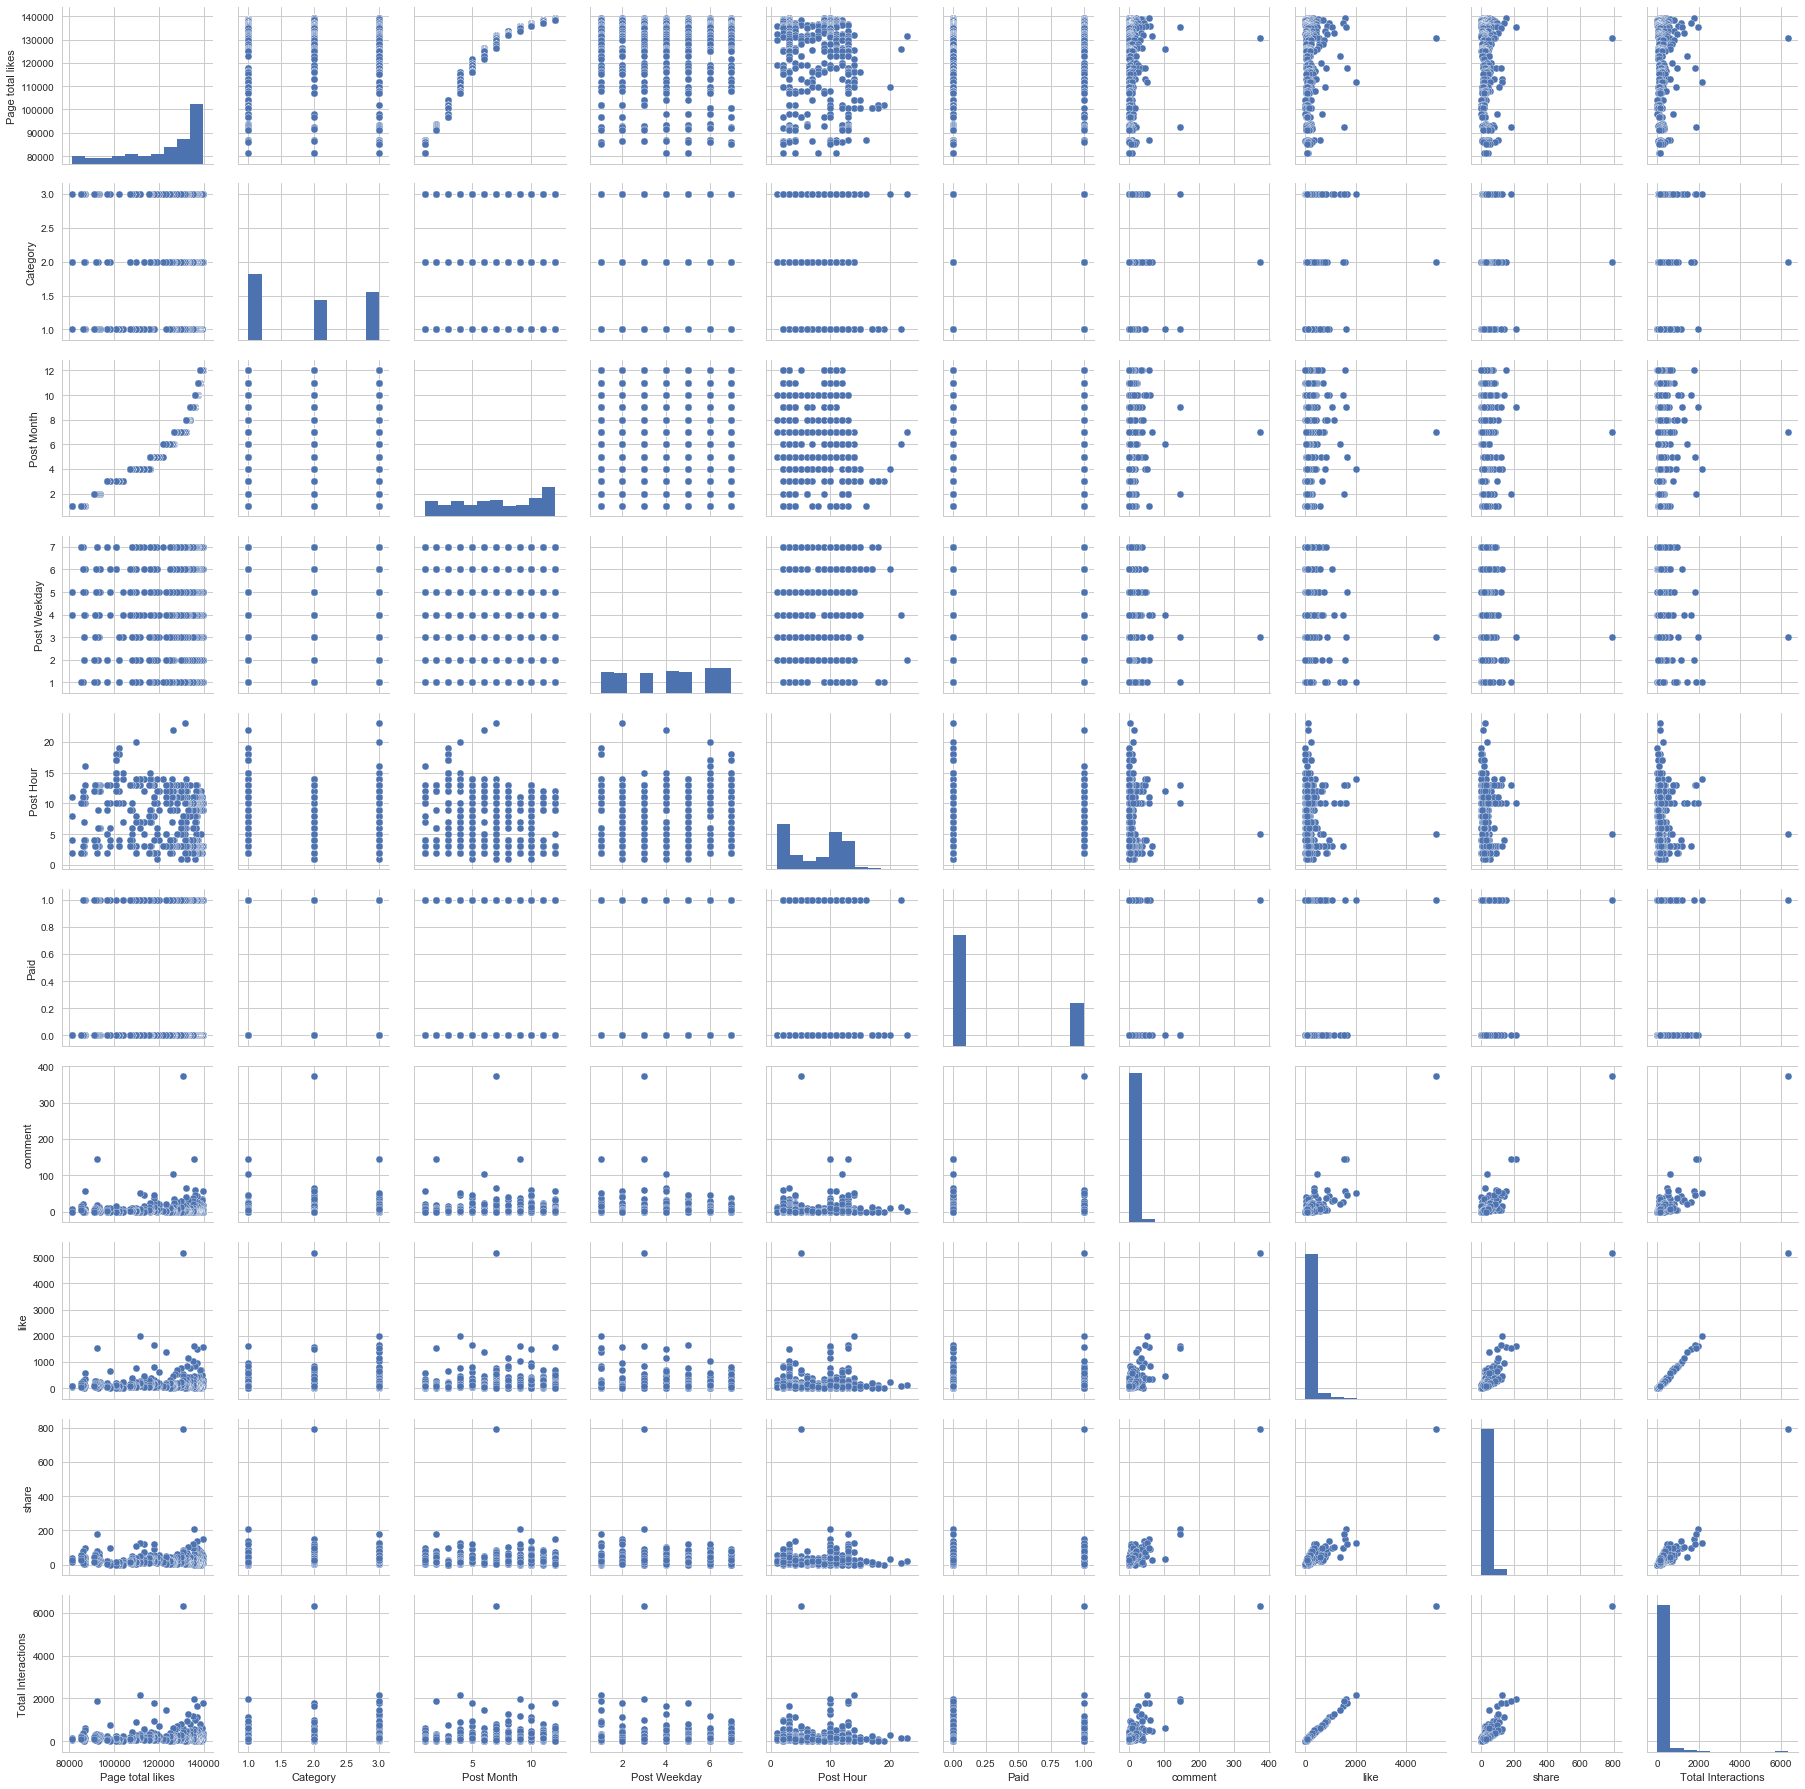

In [831]:
df['Type'] = df['Type'].apply(lambda x: str(x))
plotdf = df.drop(df.columns[7:15],axis =1)
sns.pairplot(data=plotdf)

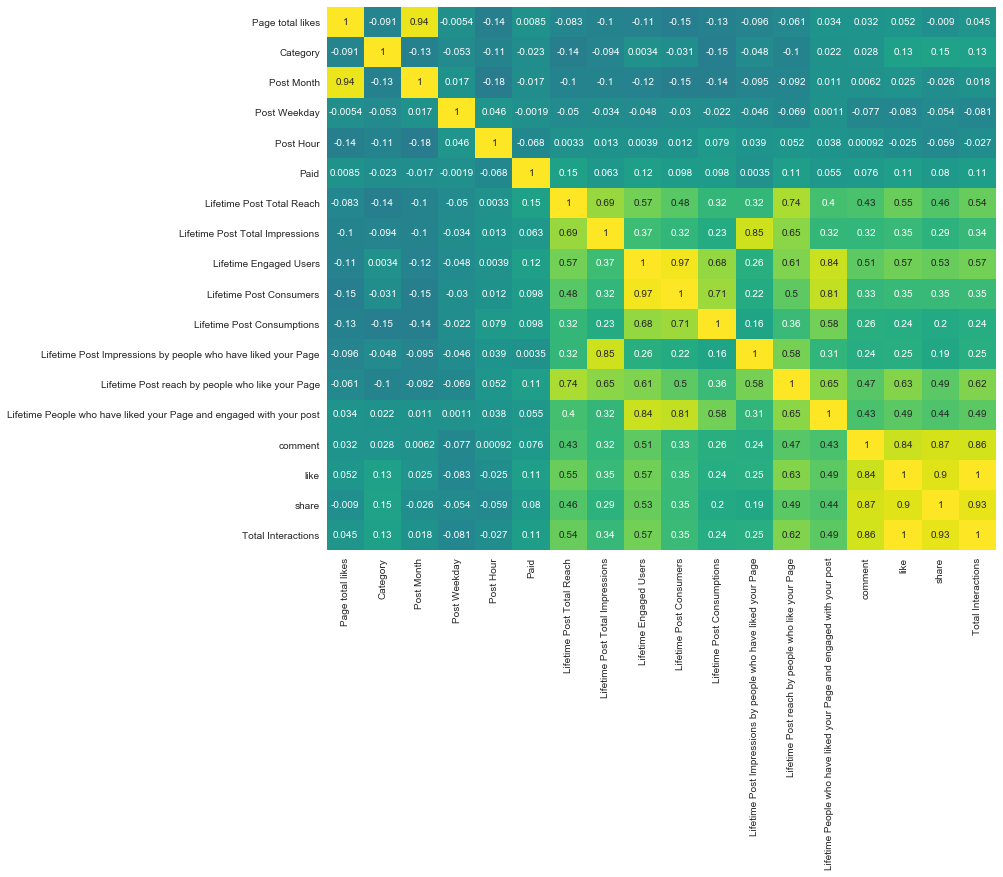

In [6]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),cmap='viridis',annot=True,cbar=False)

The lifetime metrics all appear to have high correlation wiith the engagement metrics- likes, comments, shares, total interactions (a sum of the 3 prior features). This suggests a regression model predicting total reach might have suitable performance.

### EDA of Lifetime Metrics

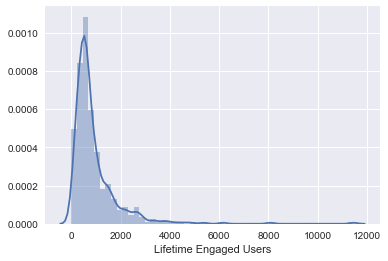

In [7]:
sns.distplot(df['Lifetime Engaged Users'])

The majority of posts engaged between 0 and 2000 users, with a dramatic left skew. The max was 12000 users engaged. 

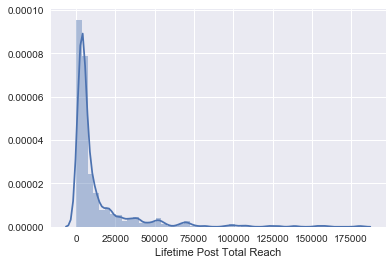

In [10]:
sns.distplot(df['Lifetime Post Total Reach'])
#plt.xlim(0,15000)

The majority of posts reached between 0 and 8000 users, and similar to the engaged users, a dramatic left skew.

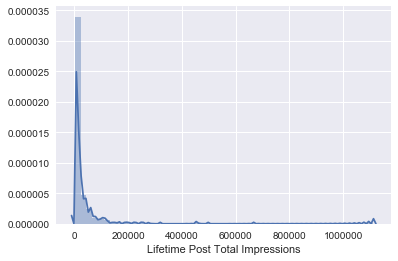

In [17]:
sns.distplot(df['Lifetime Post Total Impressions'],bins=50)
#plt.xlim(0,15000)

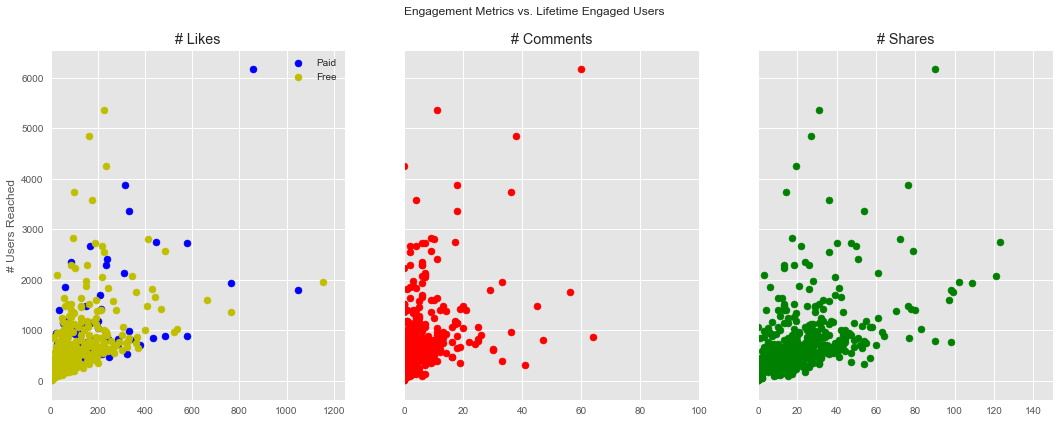

In [201]:
plt.style.use('ggplot')

fig, ax = plt.subplots(ncols=3,nrows=1,sharey=True,figsize=(16,6))
paid = df[df['Paid']==1]
free = df[df['Paid']==0]


ax[0].scatter(paid['like'],paid['Lifetime Engaged Users'],color='b')
ax[0].scatter(free['like'],free['Lifetime Engaged Users'],color='y')
ax[0].set_title('# Likes')
ax[0].set_xlim(0,1250)
ax[0].legend(labels=['Paid','Free'])

ax[1].scatter(df['comment'],df['Lifetime Engaged Users'],color='r')
ax[1].set_title('# Comments')
ax[1].set_xlim(0,100)

ax[2].scatter(df['share'],df['Lifetime Engaged Users'],color='g')
ax[2].set_title('# Shares')
ax[2].set_xlim(0,150)

ax[0].set_ylabel("# Users Reached")

fig.suptitle('Engagement Metrics vs. Lifetime Engaged Users',fontsize=12)

#fig.tight_layout()
#fig.canvas.set_window_title('Engagement Metrics vs. Lifetime Reach') 
#set_title('')

We see positive relationships most explicitly between Lifetime Engaged Users and likes/shares, and less so for comments.

# Modeling: Can we predict how many users a post will engage?

The goal is to get an estimate of how many users a post engaged over its lifetime, by using its categorical featues (when it was posted, what type of post) and engagement metrics (likes, shares, comments). 

This could be useful when measuring post performance.

In [64]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

### Removing Outliers and Binarizing Categorical Variables

To remove the decent amount of outliers, I will remove any data points (rows) that are above the 90th percentile.

After, I will span the categorical columns out into binary features. To avoid multicolinearity, I will be taking n-1 columns for each feature.

#### Removing Outliers

In [65]:
outlierCut = np.percentile(df['Lifetime Post Total Reach'],90)
outlierCut

37116.800000000003

In [66]:
df = df[df['Lifetime Post Total Reach']<outlierCut]

The function below will translate the weekdays to their labels, rather than 1-7.

In [67]:
def Weekday(x):
    if x == 1:
        return 'Su'
    elif x== 2:
        return 'Mo'
    elif x == 3:
        return 'Tu'
    elif x == 4:
        return 'We'
    elif x == 5:
        return 'Th'
    elif x ==6:
        return 'Fr'
    elif x == 7:
        return "Sa"

df['Weekday'] = df['Post Weekday'].apply(lambda x: Weekday(x))

#### Spanning out categorical columns

In [68]:
dayDf = pd.get_dummies(df['Weekday'])

In [69]:
df = pd.concat([df,dayDf],axis=1)

In [70]:
hours = list(range(0,18))
#hours
for i in hours:
    hours[i] = str(hours[i])
    hours[i]='hr_'+ hours[i]
    #print str(hours[i])

In [71]:
hourDf = pd.get_dummies(df['Post Hour'],prefix='hr_')
df = pd.concat([df,hourDf],axis=1)
monthDf = pd.get_dummies(df['Post Month'],prefix='Mo')
df = pd.concat([df,monthDf],axis=1)
df['Video'] = pd.get_dummies(df['Type'])['Video']
df['Status'] = pd.get_dummies(df['Type'])['Status']
df['Photo'] = pd.get_dummies(df['Type'])['Photo']
df['Cat_1'] = pd.get_dummies(df['Category'])[1]
df['Cat_2'] = pd.get_dummies(df['Category'])[2]
#To avoid multicollinearity with the post types I am not including Links.

In [72]:
df.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,...,Mo_8,Mo_9,Mo_10,Mo_11,Mo_12,Video,Status,Photo,Cat_1,Cat_2
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,...,0,0,0,0,1,0,0,1,0,1
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,...,0,0,0,0,1,0,1,0,0,1
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,...,0,0,0,0,1,0,0,1,0,0
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,...,0,0,0,0,1,0,0,1,0,1
5,139441,Status,2,12,1,9,0.0,10472,20849,1191,...,0,0,0,0,1,0,1,0,0,1


### Train Test Split

In [73]:
df.columns

Index([u'Page total likes', u'Type', u'Category', u'Post Month',
       u'Post Weekday', u'Post Hour', u'Paid', u'Lifetime Post Total Reach',
       u'Lifetime Post Total Impressions', u'Lifetime Engaged Users',
       u'Lifetime Post Consumers', u'Lifetime Post Consumptions',
       u'Lifetime Post Impressions by people who have liked your Page',
       u'Lifetime Post reach by people who like your Page',
       u'Lifetime People who have liked your Page and engaged with your post',
       u'comment', u'like', u'share', u'Total Interactions', u'Weekday', u'Fr',
       u'Mo', u'Sa', u'Su', u'Th', u'Tu', u'We', u'hr__1', u'hr__2', u'hr__3',
       u'hr__4', u'hr__5', u'hr__6', u'hr__7', u'hr__8', u'hr__9', u'hr__10',
       u'hr__11', u'hr__12', u'hr__13', u'hr__14', u'hr__15', u'hr__16',
       u'hr__17', u'hr__18', u'hr__19', u'hr__20', u'hr__22', u'hr__23',
       u'Mo_1', u'Mo_2', u'Mo_3', u'Mo_4', u'Mo_5', u'Mo_6', u'Mo_7', u'Mo_8',
       u'Mo_9', u'Mo_10', u'Mo_11', u'Mo_12', u'V

In [205]:
#
x = df[['Page total likes','Paid','Video','Status','Photo','Total Interactions',#"like",'comment','share',
    'Cat_1','Cat_2','Mo','Tu','Sa',"We",'Th','Fr',
       'hr__17','hr__1','hr__2','hr__3','hr__4','hr__5', 'hr__6','hr__7','hr__8',
        'hr__9','hr__10','hr__11','hr__12','hr__13','hr__14','hr__15','hr__16','Mo_1',
       'Mo_2','Mo_12','Mo_4','Mo_5','Mo_6','Mo_7','Mo_8','Mo_9','Mo_11','Mo_10']]
y = df['Lifetime Engaged Users']

The train test split will be with a test size of 0.3, and a random state of 50. With 500 samples a 30% split should not lead to overfitting.

In [206]:
x_train,x_test,y_train, y_test = train_test_split(x,
                                                  y, test_size=0.2,
                                                  random_state=42)

In [207]:
y_test.count()

90

In [208]:
x_test.columns

Index([u'Page total likes', u'Paid', u'Video', u'Status', u'Photo',
       u'Total Interactions', u'Cat_1', u'Cat_2', u'Mo', u'Tu', u'Sa', u'We',
       u'Th', u'Fr', u'hr__17', u'hr__1', u'hr__2', u'hr__3', u'hr__4',
       u'hr__5', u'hr__6', u'hr__7', u'hr__8', u'hr__9', u'hr__10', u'hr__11',
       u'hr__12', u'hr__13', u'hr__14', u'hr__15', u'hr__16', u'Mo_1', u'Mo_2',
       u'Mo_12', u'Mo_4', u'Mo_5', u'Mo_6', u'Mo_7', u'Mo_8', u'Mo_9',
       u'Mo_11', u'Mo_10'],
      dtype='object')

## Linear and Lasso Regression

I will use both a Linear Regression model and a Lasso Regression model. The former to serve as a benchmark, and the latter to reduce dimensionality when I use the Random Forest model, which will help overfitting.

In [209]:
reg = linear_model.LinearRegression(normalize=True)
lasso = linear_model.Lasso()
reg.fit(x_train,y_train)
lasso.fit(x_train,y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

The Lasso model functions like a Linear Regression model, but places a weight of 0 for features that do not contain useful information.
See below:

In [210]:
lasso.coef_

array([ -9.41272082e-03,   6.15305563e+01,   1.01164212e+03,
         1.51167373e+03,   2.52938494e+02,   2.02241294e+00,
         2.41080409e+02,   7.07935216e+01,  -1.33364878e+02,
         6.57333206e+01,   5.56283972e+01,  -1.65775042e+02,
        -8.77413243e+01,   0.00000000e+00,   0.00000000e+00,
         4.61786535e+01,  -1.87574200e+01,  -2.21987856e+01,
        -7.43906082e+01,   8.80754479e+01,  -0.00000000e+00,
        -1.41585649e+01,  -3.15432213e+01,   1.29811385e+02,
         8.09385830e+01,   3.81379291e+01,   6.80775931e+01,
         7.97578626e+01,  -0.00000000e+00,  -2.71051084e+02,
         0.00000000e+00,   1.73092912e+02,   4.45996961e+02,
         9.67270540e+01,   3.93190020e+01,  -0.00000000e+00,
         2.92426810e+02,   1.64038159e+02,  -0.00000000e+00,
         9.81049293e+01,  -2.13289316e+02,  -0.00000000e+00])

In [211]:
x_train.columns

Index([u'Page total likes', u'Paid', u'Video', u'Status', u'Photo',
       u'Total Interactions', u'Cat_1', u'Cat_2', u'Mo', u'Tu', u'Sa', u'We',
       u'Th', u'Fr', u'hr__17', u'hr__1', u'hr__2', u'hr__3', u'hr__4',
       u'hr__5', u'hr__6', u'hr__7', u'hr__8', u'hr__9', u'hr__10', u'hr__11',
       u'hr__12', u'hr__13', u'hr__14', u'hr__15', u'hr__16', u'Mo_1', u'Mo_2',
       u'Mo_12', u'Mo_4', u'Mo_5', u'Mo_6', u'Mo_7', u'Mo_8', u'Mo_9',
       u'Mo_11', u'Mo_10'],
      dtype='object')

##### Extract features from lasso:

In [220]:
lassV = pd.DataFrame()
lassV['Variable'] = list(x_train.columns)
lassV['Importance'] = lasso.coef_
lassoVars = lassV[lassV['Importance'] > 0]
lassoVars = list(lassoVars['Variable'])

#### Model Validation

##### Get predictions for Linear Regression and Lasso

In [221]:
pred = reg.predict(x_test)
pred_train = reg.predict(x_train)

lpred = lasso.predict(x_test)
lpred_train = lasso.predict(x_train)

##### Score models

In [222]:
testScore = r2_score(y_pred=pred,y_true=y_test)
trainScore = r2_score(y_pred=pred_train,y_true=y_train)

ltestScore = r2_score(y_pred=lpred,y_true=y_test)
ltrainScore = r2_score(y_pred=lpred_train,y_true=y_train)

In [223]:
lrResults = pd.DataFrame()
lrResults['Score'] = [trainScore,testScore]
lrResults['Step'] = ['train','test']

lrResults

,Score,Step
0,0.646754,train
1,0.683057,test


In [224]:
lassoResults = pd.DataFrame()
lassoResults['Score'] = [ltrainScore,ltestScore]
lassoResults['Step'] = ['train','test']

lassoResults

,Score,Step
0,0.640077,train
1,0.686063,test


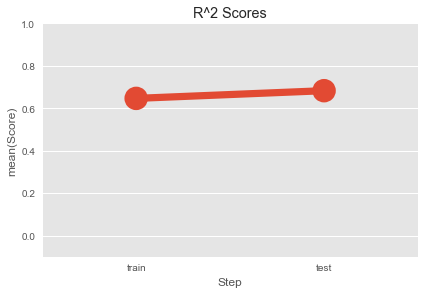

In [225]:
sns.pointplot(y=lrResults['Score'],x=lrResults['Step'])
plt.ylim([-.1,1])
plt.title('R^2 Scores')
plt.savefig('LRScores.png',bbox_inches='tight')

##### Results

The linear regression model performed solid overall. 
- No overfitting: the R2 value rose .045 points from train to test
- Moderate predictive power: .64 R2 train, .68 in test

I had to tune the test set division to 10% of the total dataset, to get the highest R2 value.

#### Let's try a different approach- a Random Forest Regressor.

## Random Forest Regression

In [88]:
from sklearn.ensemble import RandomForestRegressor

As the Linear Regression train/test split was tuned for, I will set the split back to my preliminary value of 0.3

In [226]:
x = df[lassoVars]

x_train,x_test,y_train, y_test = train_test_split(x,
                                                  y, test_size=0.2,
                                                  random_state=42)

For the Random Forest we will use a min samples split of 10, as to avoid overfitting.

In [227]:
rf = RandomForestRegressor(n_estimators=500,min_samples_split=15)
rf.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=15, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

#### Model Validation

In [228]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
predicted_train = rf.predict(x_train)
predicted_test = rf.predict(x_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)

print('Test data R-2 score: {}').format(test_score)
print('Test data Spearman correlation: {}').format(spearman[0])
print('Test data Pearson correlation: {}').format(pearson[0])

train_score = r2_score(y_train, predicted_train)
spearmanTrain = spearmanr(y_train, predicted_train)
pearsonTrain = pearsonr(y_train, predicted_train)

print(' ')

print('Train data R-2 score: {}').format(train_score)
print('Train data Spearman correlation: {}').format(spearmanTrain[0])
print('Train data Pearson correlation: {}').format(pearsonTrain[0])

Test data R-2 score: 0.641601191261
Test data Spearman correlation: 0.787851848253
Test data Pearson correlation: 0.844073365797
 
Train data R-2 score: 0.750168073692
Train data Spearman correlation: 0.895216569654
Train data Pearson correlation: 0.870850738121


In [229]:
RFperf = pd.DataFrame()
RFperf['Score'] = [round(train_score,3),round(test_score,3)]
RFperf['Step'] = ['train','test']
RFperf

,Score,Step
0,0.750,train
1,0.642,test


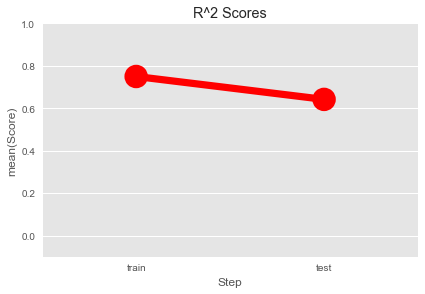

In [230]:
sns.pointplot(y=RFperf['Score'],x=RFperf['Step'],color='Red')
plt.ylim([-.1,1])
plt.title('R^2 Scores')
plt.savefig('RFScores.png',bbox_inches='tight')

Best results came from 
- RF parameters:
    - 500 estimators
    - 15 min sample split 
- Train/test split of 0.2

We had solid performance in the test set, with:
    - .772 r^2
    - .919 Spearman Correlation

But the model showed some signs of overfitting when exposed to the test set:
    - reduction of .15 in the r^2
    - reduction of .10 in test Spearman Correlation
    
    
One reason that there could be overfitting is the large amount of features in the model. We can take the feature importance to get the top 15 features, then iterate through the Random Forest again, and see if overfitting persists.

#### Feature Importance - which are the most important features?

In [231]:
predicted_test = rf.predict(x_test)

fI = pd.DataFrame()
fI['Variable'] = list(x_train.columns)
fI['Importance'] = rf.feature_importances_
fI.sort_values(by='Importance',ascending=False)[0:15]

,Variable,Importance
4,Total Interactions,0.378832
2,Status,0.351377
17,Mo_2,0.067728
3,Photo,0.054180
1,Video,0.017713
16,Mo_1,0.017292
11,hr__9,0.013583
20,Mo_6,0.013132
8,Sa,0.010954
5,Cat_1,0.010155


In [190]:
topVars= list(fI.sort_values(by='Importance',ascending=False)[0:15]['Variable'])
topVars

['Total Interactions',
 'Status',
 'Page total likes',
 'Photo',
 'Video',
 'hr__9',
 'Mo_2',
 'Cat_1',
 'Mo_9',
 'hr__12',
 'Mo_6',
 'Th',
 'hr__10',
 'hr__4',
 'Sa']

#### Can we improve the model by using only the top 15 features?

In [232]:
x = df[topVars]

In [233]:
x_train,x_test,y_train, y_test = train_test_split(x,
                                                  y, test_size=0.3,
                                                  random_state=50)

In [234]:
rf = RandomForestRegressor(n_estimators=500,min_samples_split=15)
rf.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=15, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [235]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
predicted_train = rf.predict(x_train)
predicted_test = rf.predict(x_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)

#print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print('Test data R-2 score: {}').format(test_score)
print('Test data Spearman correlation: {}').format(spearman[0])
print('Test data Pearson correlation: {}').format(pearson[0])

train_score = r2_score(y_train, predicted_train)
spearmanTrain = spearmanr(y_train, predicted_train)
pearsonTrain = pearsonr(y_train, predicted_train)

print(' ')

#print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print('Train data R-2 score: {}').format(train_score)
print('Train data Spearman correlation: {}').format(spearmanTrain[0])
print('Train data Pearson correlation: {}').format(pearsonTrain[0])

Test data R-2 score: 0.726526435057
Test data Spearman correlation: 0.868639520944
Test data Pearson correlation: 0.85809960871
 
Train data R-2 score: 0.750221838871
Train data Spearman correlation: 0.917611998929
Train data Pearson correlation: 0.87740530291


The model performed substantially better when taking the top 15 features by importance from the old model. In fact, it reduced overfitting (difference in train/test r^2 is now 0.03) and by all metrics is very consistent from training to test performance.

### Modeling Conclusion

After iterating through a random forest using the most important variables and seeing substantial improvement, this suggests that Lifetime Engaged Users can be modeled for to a reasonable degree. 

A tuned Random Forest performed better than a Lasso Regression model to a large degree, with a difference in test r^2 values of .12. 

This model can provide value by giving posters an accurate estimate of how many users they engaged by post, particularly useful for monthly/quarterly reporting.

## Takeaways

1. Paid posts on average have higher engagement 
2. Paid Status/Photo and Category 1 and 2 posts have the highest improvement so
    - more paid posts of these types
3. Video Posts have the highest average engagement, and its not close 
	- more Video posts
4. Posting Monday in the mid-morning and Wednesday in the early morning 
    - Identify and post during times of high engagement
5. Place importance on increasing Page Likes 
    - higher probability that a post has “high” engagement
Need a richer dataset to predict accurately
    - identify potentially useful data points and collect them



## References


(Moro et al., 2016) Moro, S., Rita, P., & Vala, B. (2016). Predicting social media performance metrics and evaluation of the impact on brand building: A data mining approach. Journal of Business Research, 69(9), 3341-3351. 
